In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

We require the latest version of torchvision

In [1]:
pip install albumentations

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
  Using cached scikit_image-0.22.0-cp39-cp39-win_amd64.whl.metadata (13 kB)
   ---------------------------------------- 0.0/130.5 kB ? eta -:--:--
   ---------------------------------- ----- 112.6/130.5 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 130.5/130.5 kB 1.5 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.5 MB 1.3 MB/s eta 0:00:30
   ---------------------------------------- 0.2/38.5 MB 2.1 MB/s eta 0:00:19
    --------------------------------------- 0.6/38.5 MB 4.1 MB/s eta 0:00:10
    --------------------------------------- 0.9/38.5 MB 4.7 MB/s eta 0:00:08
   - -------------------------------------- 1.4/38.5 MB 5.8 MB/s eta 0:00:07
   - -------------------------------------- 1.8/38.5 MB 6.4 MB/s eta 0:00:06
   -- --------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kraken 4.3.13 requires numpy~=1.23.0, but you have numpy 1.26.4 which is incompatible.
kraken 4.3.13 requires scikit-image<=0.19.3,>=0.17.0, but you have scikit-image 0.22.0 which is incompatible.
kraken 4.3.13 requires scikit-learn~=1.2.1, but you have scikit-learn 1.4.1.post1 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.26.4 which is incompatible.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.10.0 which is incompatible.


In [3]:
!pip install -U torchvision # We need a new versino of torchvision for this project

ERROR: Invalid requirement: '#'


In [3]:
pip install --user albumentations

  Using cached albumentations-1.4.1-py3-none-any.whl.metadata (36 kB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached albumentations-1.4.1-py3-none-any.whl (130 kB)
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl (38.5 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\0871\\AppData\\Roaming\\Python\\Python310\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



In [2]:
pip install albumentations --user

  Using cached albumentations-1.4.1-py3-none-any.whl.metadata (36 kB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached albumentations-1.4.1-py3-none-any.whl (130 kB)
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl (38.5 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\0871\\AppData\\Roaming\\Python\\Python310\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



Here are all the necessary libraries

In [2]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [4]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cpu
0.15.2+cpu


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [6]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

   ---------------------------------------- 0.0/85.1 kB ? eta -:--:--
   -------------------------------------- - 81.9/85.1 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 85.1/85.1 kB 960.2 kB/s eta 0:00:00


In [5]:
from pycocotools.coco import COCO

In [6]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [7]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [8]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [9]:
dataset_path = "Aquarium Combined/"

In [10]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

This code just gets a list of classes

In [11]:
classes = [i[1]['name'] for i in categories.items()]
classes


['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [12]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

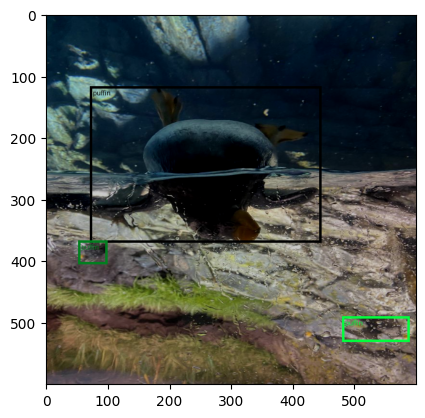

In [13]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [14]:
len(train_dataset)

447

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [15]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
train_dataset

Dataset AquariumDetection
    Number of datapoints: 447
    Root location: Aquarium Combined/
    Compose([
  Resize(always_apply=False, p=1, height=600, width=600, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.3),
  VerticalFlip(always_apply=False, p=0.3),
  RandomBrightnessContrast(always_apply=False, p=0.1, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  ColorJitter(always_apply=False, p=0.1, brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=[-0.2, 0.2]),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={}, is_check_shapes=True)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [18]:
from torch.utils.data import DataLoader

# Assuming 'dataset' is your dataset object
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0,collate_fn=collate_fn)

# Now try to get the first batch again
try:
    images, targets = next(iter(train_loader))
    print(images)
    print(targets)
except Exception as e:
    print(f"Error: {e}")


(tensor([[[0.1804, 0.2118, 0.2392,  ..., 0.3373, 0.3333, 0.3333],
         [0.1686, 0.1686, 0.1725,  ..., 0.3373, 0.3333, 0.3333],
         [0.1725, 0.1608, 0.1569,  ..., 0.3373, 0.3333, 0.3333],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0039]],

        [[0.1961, 0.2235, 0.2510,  ..., 0.3020, 0.3020, 0.3020],
         [0.1843, 0.1843, 0.1843,  ..., 0.3059, 0.3020, 0.3020],
         [0.1843, 0.1725, 0.1686,  ..., 0.3059, 0.3020, 0.3020],
         ...,
         [0.1725, 0.1725, 0.1725,  ..., 0.1255, 0.1137, 0.1255],
         [0.1725, 0.1725, 0.1725,  ..., 0.1294, 0.1176, 0.1255],
         [0.1725, 0.1725, 0.1725,  ..., 0.1333, 0.1255, 0.1255]],

        [[0.1922, 0.2353, 0.2706,  ..., 0.2157, 0.2118, 0.2118],
         [0.1882, 0.1922, 0.2118,  ..., 0.2157, 0.2118, 0.2118],
         [0.2039, 0.1961, 0.2078,  ..., 0.2196, 0.2157, 0

In [19]:
images,targets = next(iter(train_loader))
print(images)
print(targets)

(tensor([[[0.1804, 0.2118, 0.2392,  ..., 0.3373, 0.3333, 0.3333],
         [0.1686, 0.1686, 0.1725,  ..., 0.3373, 0.3333, 0.3333],
         [0.1725, 0.1608, 0.1569,  ..., 0.3373, 0.3333, 0.3333],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0039]],

        [[0.1961, 0.2235, 0.2510,  ..., 0.3020, 0.3020, 0.3020],
         [0.1843, 0.1843, 0.1843,  ..., 0.3059, 0.3020, 0.3020],
         [0.1843, 0.1725, 0.1686,  ..., 0.3059, 0.3020, 0.3020],
         ...,
         [0.1725, 0.1725, 0.1725,  ..., 0.1255, 0.1137, 0.1255],
         [0.1725, 0.1725, 0.1725,  ..., 0.1294, 0.1176, 0.1255],
         [0.1725, 0.1725, 0.1725,  ..., 0.1333, 0.1255, 0.1255]],

        [[0.1922, 0.2353, 0.2706,  ..., 0.2157, 0.2118, 0.2118],
         [0.1882, 0.1922, 0.2118,  ..., 0.2157, 0.2118, 0.2118],
         [0.2039, 0.1961, 0.2078,  ..., 0.2196, 0.2157, 0

In [20]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error
output

{'loss_classifier': tensor(1.7652, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.3366, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.2152, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0249, grad_fn=<DivBackward0>)}

In [21]:
import torch

# Check if CUDA (GPU support) is available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cpu


In [22]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [22]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [23]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [25]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

In [26]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er

In [25]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import sys
import os

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)  # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")  # Train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    all_losses_dict = pd.DataFrame(all_losses_dict)  # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box_reg: {:.6f}, loss_rpn_box_reg: {:.6f}, loss_objectness: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved at {path}")

def load_model_for_inference(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Example usage assuming model, optimizer, and train_loader are already defined:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10  # or however many you want

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    save_model(model, f"model_epoch_{epoch}.pth")

# Save the final model
final_model_path = "faster_rcnn_final_model.pth"
save_model(model, final_model_path)

# To load the model for inference
# model_for_inference = load_model_for_inference(get_model(), final_model_path, device)
# Now you can use model_for_inference for predictions


100%|██████████| 447/447 [43:45<00:00,  5.87s/it]


Epoch 0, lr: 0.010000, loss: 0.968887, loss_classifier: 0.430054, loss_box_reg: 0.339189, loss_rpn_box_reg: 0.047426, loss_objectness: 0.152218
Model saved at model_epoch_0.pth


100%|██████████| 447/447 [1:05:34<00:00,  8.80s/it]


Epoch 1, lr: 0.010000, loss: 0.852642, loss_classifier: 0.380273, loss_box_reg: 0.333841, loss_rpn_box_reg: 0.041514, loss_objectness: 0.097013
Model saved at model_epoch_1.pth


100%|██████████| 447/447 [1:01:04<00:00,  8.20s/it]


Epoch 2, lr: 0.010000, loss: 0.802116, loss_classifier: 0.353374, loss_box_reg: 0.330062, loss_rpn_box_reg: 0.039335, loss_objectness: 0.079346
Model saved at model_epoch_2.pth


100%|██████████| 447/447 [47:03<00:00,  6.32s/it]


Epoch 3, lr: 0.010000, loss: 0.752235, loss_classifier: 0.320440, loss_box_reg: 0.329880, loss_rpn_box_reg: 0.036419, loss_objectness: 0.065495
Model saved at model_epoch_3.pth


100%|██████████| 447/447 [48:36<00:00,  6.53s/it]


Epoch 4, lr: 0.010000, loss: 0.732847, loss_classifier: 0.315641, loss_box_reg: 0.329901, loss_rpn_box_reg: 0.035359, loss_objectness: 0.051947
Model saved at model_epoch_4.pth


100%|██████████| 447/447 [1:00:02<00:00,  8.06s/it]


Epoch 5, lr: 0.010000, loss: 0.719146, loss_classifier: 0.301858, loss_box_reg: 0.332158, loss_rpn_box_reg: 0.034326, loss_objectness: 0.050805
Model saved at model_epoch_5.pth


100%|██████████| 447/447 [1:02:25<00:00,  8.38s/it]


Epoch 6, lr: 0.010000, loss: 0.703122, loss_classifier: 0.288004, loss_box_reg: 0.336333, loss_rpn_box_reg: 0.033463, loss_objectness: 0.045323
Model saved at model_epoch_6.pth


100%|██████████| 447/447 [1:01:14<00:00,  8.22s/it]


Epoch 7, lr: 0.010000, loss: 0.707009, loss_classifier: 0.284152, loss_box_reg: 0.337408, loss_rpn_box_reg: 0.033411, loss_objectness: 0.052039
Model saved at model_epoch_7.pth


100%|██████████| 447/447 [47:34<00:00,  6.39s/it]


Epoch 8, lr: 0.010000, loss: 0.673301, loss_classifier: 0.270366, loss_box_reg: 0.330221, loss_rpn_box_reg: 0.032072, loss_objectness: 0.040642
Model saved at model_epoch_8.pth


100%|██████████| 447/447 [49:42<00:00,  6.67s/it]


Epoch 9, lr: 0.010000, loss: 0.681780, loss_classifier: 0.270510, loss_box_reg: 0.338758, loss_rpn_box_reg: 0.031419, loss_objectness: 0.041093
Model saved at model_epoch_9.pth
Model saved at faster_rcnn_final_model.pth


In [24]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import sys
import os

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
         
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    all_losses_dict = pd.DataFrame(all_losses_dict)
    mean_loss = np.mean(all_losses)
    print(f"Epoch {epoch}, Mean loss: {mean_loss}")
    return mean_loss

def calculate_model_accuracy(model, loader, device):
    """
    Placeholder for model accuracy calculation.
    Implement your accuracy calculation here based on your model and data.
    For object detection, this might involve calculating mAP, precision, recall, etc.
    """
    # Placeholder accuracy calculation
    accuracy = np.random.rand()  # Replace with actual calculation
    print(f"Model accuracy: {accuracy}")
    return accuracy

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved at {path}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
best_accuracy = 0.0  # Initialize best accuracy

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    current_accuracy = calculate_model_accuracy(model, train_loader, device)
    
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_model_path = f"best_model_epoch_{epoch}.pth"
        save_model(model, best_model_path)
        print(f"New best model with accuracy {best_accuracy} saved.")

# Final model saving can be omitted if you only care about the best model
# final_model_path = "faster_rcnn_final_model.pth"
# save_model(model, final_model_path)

# To load the model for inference
# best_model_for_inference = load_model_for_inference(model, best_model_path, device)
# Now you can use best_model_for_inference for predictions


100%|██████████| 447/447 [39:57<00:00,  5.36s/it]


Epoch 0, Mean loss: 0.9804151153537785
Model accuracy: 0.648342286844373
Model saved at best_model_epoch_0.pth
New best model with accuracy 0.648342286844373 saved.


100%|██████████| 447/447 [35:03<00:00,  4.71s/it]


Epoch 1, Mean loss: 0.8468827012201283
Model accuracy: 0.39423529817576075


100%|██████████| 447/447 [34:48<00:00,  4.67s/it]


Epoch 2, Mean loss: 0.7910773785122289
Model accuracy: 0.8214249272822288
Model saved at best_model_epoch_2.pth
New best model with accuracy 0.8214249272822288 saved.


100%|██████████| 447/447 [32:39<00:00,  4.38s/it]


Epoch 3, Mean loss: 0.753849708977295
Model accuracy: 0.35705331394469086


100%|██████████| 447/447 [37:59<00:00,  5.10s/it]


Epoch 4, Mean loss: 0.7479326114958564
Model accuracy: 0.9146744333402819
Model saved at best_model_epoch_4.pth
New best model with accuracy 0.9146744333402819 saved.


100%|██████████| 447/447 [47:03<00:00,  6.32s/it]


Epoch 5, Mean loss: 0.6994699469915439
Model accuracy: 0.26749698594668603


100%|██████████| 447/447 [47:43<00:00,  6.41s/it]


Epoch 6, Mean loss: 0.7131898951543791
Model accuracy: 0.4540012770461894


100%|██████████| 447/447 [49:03<00:00,  6.59s/it]


Epoch 7, Mean loss: 0.7032909903016933
Model accuracy: 0.6280036816724262


100%|██████████| 447/447 [52:23<00:00,  7.03s/it]


Epoch 8, Mean loss: 0.685210900102019
Model accuracy: 0.08468273587045738


100%|██████████| 447/447 [1:04:59<00:00,  8.72s/it]


Epoch 9, Mean loss: 0.6639950400430884
Model accuracy: 0.8016706559317569


100%|██████████| 447/447 [1:38:56<00:00, 13.28s/it]


Epoch 10, Mean loss: 0.684955447545521
Model accuracy: 0.49274099492317713


100%|██████████| 447/447 [1:40:40<00:00, 13.51s/it]


Epoch 11, Mean loss: 0.6713711291351574
Model accuracy: 0.33850654434816263


100%|██████████| 447/447 [1:43:13<00:00, 13.86s/it]


Epoch 12, Mean loss: 0.6658798991233711
Model accuracy: 0.5429989239880789


100%|██████████| 447/447 [1:41:58<00:00, 13.69s/it]


Epoch 13, Mean loss: 0.6589765218847017
Model accuracy: 0.049034051947612234


100%|██████████| 447/447 [1:41:12<00:00, 13.59s/it]


Epoch 14, Mean loss: 0.6535599531076631
Model accuracy: 0.3264171785851715


100%|██████████| 447/447 [1:34:07<00:00, 12.63s/it]


Epoch 15, Mean loss: 0.6629305679592777
Model accuracy: 0.7652003325089227


100%|██████████| 447/447 [1:14:09<00:00,  9.95s/it]


Epoch 16, Mean loss: 0.653443093884578
Model accuracy: 0.27603490914188633


100%|██████████| 447/447 [1:19:14<00:00, 10.64s/it]


Epoch 17, Mean loss: 0.6246711111542096
Model accuracy: 0.42025100640180657


100%|██████████| 447/447 [1:18:56<00:00, 10.60s/it]


Epoch 18, Mean loss: 0.6366538632269407
Model accuracy: 0.9916488401065561
Model saved at best_model_epoch_18.pth
New best model with accuracy 0.9916488401065561 saved.


100%|██████████| 447/447 [1:21:47<00:00, 10.98s/it]


Epoch 19, Mean loss: 0.6334756440764305
Model accuracy: 0.06068038248840091


100%|██████████| 447/447 [1:11:13<00:00,  9.56s/it]


Epoch 20, Mean loss: 0.6170439967589757
Model accuracy: 0.015607752213622539


100%|██████████| 447/447 [1:08:18<00:00,  9.17s/it]


Epoch 21, Mean loss: 0.623702835799997
Model accuracy: 0.3609394185524577


100%|██████████| 447/447 [1:17:49<00:00, 10.45s/it]


Epoch 22, Mean loss: 0.6420426935757566
Model accuracy: 0.8391199938120384


100%|██████████| 447/447 [2:30:50<00:00, 20.25s/it]  


Epoch 23, Mean loss: 0.6368638819429432
Model accuracy: 0.6371589089594855


100%|██████████| 447/447 [2:07:06<00:00, 17.06s/it]  


Epoch 24, Mean loss: 0.6269326964080734
Model accuracy: 0.21157322575507675


100%|██████████| 447/447 [2:20:50<00:00, 18.91s/it]  


Epoch 25, Mean loss: 0.6361188289169764
Model accuracy: 0.09912008531851435


100%|██████████| 447/447 [1:09:59<00:00,  9.39s/it]


Epoch 26, Mean loss: 0.6361382105439835
Model accuracy: 0.5344310569801101


100%|██████████| 447/447 [49:44<00:00,  6.68s/it]


Epoch 27, Mean loss: 0.6299682035875533
Model accuracy: 0.48994656730843955


100%|██████████| 447/447 [49:18<00:00,  6.62s/it]


Epoch 28, Mean loss: 0.6168052891156818
Model accuracy: 0.17307328275281708


100%|██████████| 447/447 [48:53<00:00,  6.56s/it]


Epoch 29, Mean loss: 0.6156291833993306
Model accuracy: 0.7736681118217892


100%|██████████| 447/447 [47:50<00:00,  6.42s/it]


Epoch 30, Mean loss: 0.6213990246889575
Model accuracy: 0.9225320634884814


100%|██████████| 447/447 [48:35<00:00,  6.52s/it]


Epoch 31, Mean loss: 0.6233416999913168
Model accuracy: 0.12115465975838657


100%|██████████| 447/447 [48:30<00:00,  6.51s/it]


Epoch 32, Mean loss: 0.6545367894456691
Model accuracy: 0.49133703113680627


100%|██████████| 447/447 [1:05:45<00:00,  8.83s/it]


Epoch 33, Mean loss: 0.6151692677264246
Model accuracy: 0.9499754747696331


100%|██████████| 447/447 [1:28:49<00:00, 11.92s/it]  


Epoch 34, Mean loss: 0.606759366723115
Model accuracy: 0.9262341034382399


100%|██████████| 447/447 [2:28:57<00:00, 20.00s/it]  


Epoch 35, Mean loss: 0.6110706347513786
Model accuracy: 0.3678538227995771


100%|██████████| 447/447 [49:10<00:00,  6.60s/it]  


Epoch 36, Mean loss: 0.6343417117326319
Model accuracy: 0.7097249559987089


100%|██████████| 447/447 [44:06<00:00,  5.92s/it]


Epoch 37, Mean loss: 0.621174036706454
Model accuracy: 0.2633137469387533


100%|██████████| 447/447 [41:58<00:00,  5.63s/it]


Epoch 38, Mean loss: 0.5975906578053031
Model accuracy: 0.6269062519845291


100%|██████████| 447/447 [40:53<00:00,  5.49s/it]


Epoch 39, Mean loss: 0.6231289672638213
Model accuracy: 0.4952726114929994


100%|██████████| 447/447 [37:11<00:00,  4.99s/it]


Epoch 40, Mean loss: 0.6259833544292706
Model accuracy: 0.5140011140870624


100%|██████████| 447/447 [36:36<00:00,  4.91s/it]


Epoch 41, Mean loss: 0.6155673235621495
Model accuracy: 0.6067249222054051


100%|██████████| 447/447 [37:08<00:00,  4.98s/it]


Epoch 42, Mean loss: 0.6138306151100453
Model accuracy: 0.24605580091144597


100%|██████████| 447/447 [34:56<00:00,  4.69s/it]


Epoch 43, Mean loss: 0.6228585819269987
Model accuracy: 0.3175520180329764


100%|██████████| 447/447 [36:58<00:00,  4.96s/it]


Epoch 44, Mean loss: 0.6185858071317075
Model accuracy: 0.3221324886793433


100%|██████████| 447/447 [42:13<00:00,  5.67s/it]


Epoch 45, Mean loss: 0.6197830865980528
Model accuracy: 0.1429581840080737


100%|██████████| 447/447 [41:25<00:00,  5.56s/it]


Epoch 46, Mean loss: 0.6334809242212266
Model accuracy: 0.9278896605995387


100%|██████████| 447/447 [43:04<00:00,  5.78s/it]


Epoch 47, Mean loss: 0.5969336750923387
Model accuracy: 0.8737492912803162


100%|██████████| 447/447 [44:33<00:00,  5.98s/it]


Epoch 48, Mean loss: 0.6260030781162665
Model accuracy: 0.6223850820256118


100%|██████████| 447/447 [47:22<00:00,  6.36s/it]

Epoch 49, Mean loss: 0.6238083563394995
Model accuracy: 0.8985334498794275


## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [26]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [27]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [28]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [29]:
# it did learn

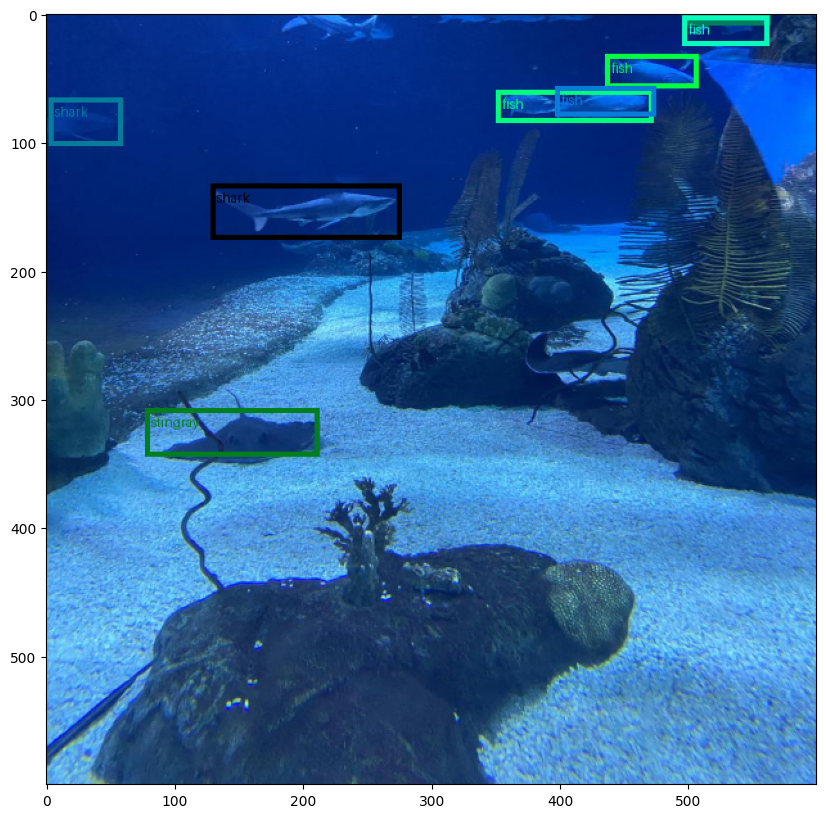

In [30]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))